In [1]:
#MODULES IMPORTATION
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,BaggingRegressor,BaggingClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVC,SVR
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,mean_squared_error,mean_absolute_error,accuracy_score,precision_score,f1_score,recall_score 
import warnings
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix,auc
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import datetime as dt
from sklearn.feature_selection import RFE,SelectKBest,f_classif
import statsmodels.api as sm

In [2]:
#Dataset Importation
ticker=['MSFT']
start=dt.datetime(2017,4,10)
end=dt.datetime(2023,4,10)
df=yf.download(ticker,start,end,interval='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-04-10,65.610001,65.820000,65.360001,65.529999,60.317131,17952700
2017-04-11,65.599998,65.610001,64.849998,65.480003,60.271122,18791500
2017-04-12,65.419998,65.510002,65.110001,65.230003,60.041008,17108500
2017-04-13,65.290001,65.860001,64.949997,64.949997,59.783276,17896500
2017-04-17,65.040001,65.489998,65.010002,65.480003,60.271122,16689300


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2017-04-10 to 2023-04-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1509 non-null   float64
 1   High       1509 non-null   float64
 2   Low        1509 non-null   float64
 3   Close      1509 non-null   float64
 4   Adj Close  1509 non-null   float64
 5   Volume     1509 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 82.5 KB


In [5]:
df.shape

(1509, 6)

In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1.509000e+03
mean,182.064109,183.960583,180.084745,182.119523,177.213654,2.935431e+07
std,80.146676,81.052568,79.201770,80.172038,80.693079,1.259326e+07
min,65.040001,65.489998,64.849998,64.949997,59.783276,7.425600e+06
25%,106.750000,107.900002,105.389999,106.809998,101.252014,2.146110e+07
50%,175.800003,178.639999,173.800003,177.039993,171.415649,2.631660e+07
75%,251.229996,254.229996,249.389999,252.179993,248.817291,3.352910e+07
max,344.619995,349.670013,342.200012,343.109985,337.621124,1.112421e+08


In [7]:
#DATA PREPROCESSING
df['price_diff']=df['Close'] - df['Close'].shift(1)
df['Trend']=(df['price_diff'] > 0).astype(int)
df.head()
df=df.dropna()
df.drop(['price_diff','Volume'],inplace=True,axis=1)
df['H-L']=df['High']-df['Low']
df['C-O']=df['Close']-df['Open']
d=df['Close'].diff()
g=d.where(d>0,0)
l=-d.where(d<0,0)
a_g=g.rolling(window=14).mean()
a_l=l.rolling(window=14).mean()
rsi=a_g/a_l
df['rsi'] = 100-(100/(1+rsi))
df["MA7"]=df['Close'].rolling(window=7).mean()
df["MA14"]=df['Close'].rolling(window=14).mean()
df["MA21"]=df['Close'].rolling(window=21).mean()
df["STD7"]=df['Close'].rolling(window=7).std(ddof=0)
s=df['Trend']
df=df.drop(['Trend'],axis=1)
df['Trend']=s
df=df.dropna()

In [8]:
# Data Splitting
train1 = df.loc['2017-04-10':'2021-04-10']
test1 = df.loc['2021-04-10':'2023-04-10']
train = train1.copy()
test = test1.copy()
print(train.head())
print(test.head())

                 Open       High        Low      Close  Adj Close       H-L  \
Date                                                                          
2017-05-10  68.989998  69.559998  68.919998  69.309998  63.796425  0.639999   
2017-05-11  68.360001  68.730003  68.120003  68.459999  63.014057  0.610001   
2017-05-12  68.610001  68.610001  68.040001  68.379997  62.940434  0.570000   
2017-05-15  68.139999  68.480003  67.570000  68.430000  62.986446  0.910004   
2017-05-16  68.230003  69.440002  68.160004  69.410004  64.254692  1.279999   

                 C-O        rsi        MA7       MA14       MA21      STD7  \
Date                                                                         
2017-05-10  0.320000  85.875700  69.068572  68.521429  67.446191  0.169405   
2017-05-11  0.099998  69.581746  68.948571  68.668571  67.588096  0.244039   
2017-05-12 -0.230003  60.094996  68.848571  68.729286  67.738095  0.305401   
2017-05-15  0.290001  56.589170  68.794285  68.765714  6

In [9]:
# Close price prediction (EXPERIMENT 1)
train2=train
test2=test
train2,test2=train2.dropna(),test2.dropna()
x_trainn=train2.drop(['Adj Close','Close'],axis=1)
x_testt=test2.drop(['Adj Close','Close'],axis=1)
x_train=train2.drop(['Adj Close','Close'],axis=1).values
x_test=test2.drop(['Adj Close','Close'],axis=1).values
y_train=train2['Adj Close'].values
y_test=test2['Adj Close'].values
# Normalizing dataset for first experiment
scaler = MinMaxScaler()
x_train= scaler.fit_transform(x_train)
x_test= scaler.transform(x_test)
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)


# selecting features by RFE Technique 
lr1=LinearRegression()
select=RFE(lr1,n_features_to_select=5,step=1)
select.fit(x_train,y_train)
print('Selected Features for close price prediction:',list(x_trainn.columns[select.support_]))
x_train=select.transform(x_train)
x_test=select.transform(x_test)

# Model developments for price prediction
#SVM
svm1=SVR(kernel='linear')
print('PRICE PREDICTION MODELS')
svm1.fit(x_train,y_train)
y_pred_svm1=svm1.predict(x_test)
print('SVM MSE:',mean_squared_error(y_test,y_pred_svm1))
print('SVM RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_svm1)))
print('SVM MAE:',mean_absolute_error(y_test,y_pred_svm1))
print()

#Bagging Regressor
bg1=BaggingRegressor()
bg1.fit(x_train,y_train)
y_pred_bg1=bg1.predict(x_test)
print('BG MSE:',mean_squared_error(y_test,y_pred_bg1))
print('BG RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_bg1)))
print('BG MAE:',mean_absolute_error(y_test,y_pred_bg1))
print()
#Linear regression
lr1=LinearRegression()
lr1.fit(x_train,y_train)
y_pred_lr1=lr1.predict(x_test)
print('LINEAR REGRESSION MSE:',mean_squared_error(y_test,y_pred_lr1))
print('LINEAR REGRESSION RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_lr1)))
print('LINEAR REGRESSION MAE:',mean_absolute_error(y_test,y_pred_lr1))
print('Coefficient for Linear regression:',lr1.coef_)
print('Intercept for linear regression',lr1.intercept_)
print()
#ANN
mlp1=MLPRegressor()
mlp1.fit(x_train,y_train)
y_pred_mlp1=mlp1.predict(x_test)
print('ARTIFICIAL NEURAL NETWORK MSE:',mean_squared_error(y_test,y_pred_mlp1))
print('ARTIFICIAL NEURAL NETWORK RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_mlp1)))
print('ARTIFICIAL NEURAL NETWORK MAE:',mean_absolute_error(y_test,y_pred_mlp1))
print()
#Random forest
rf1=RandomForestRegressor(n_estimators=100,random_state=0,bootstrap=True)
rf1.fit(x_train,y_train)
y_pred_rf1=rf1.predict(x_test)
print('RANDOM FOREST MSE:',mean_squared_error(y_test,y_pred_rf1))
print('RANDOM FOREST RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_rf1)))
print('RANDOM FOREST MAE:',mean_absolute_error(y_test,y_pred_rf1))
print()
#Decision Tree
dt1=DecisionTreeRegressor(criterion='squared_error',max_depth=2,random_state=0)
dt1.fit(x_train,y_train)
y_pred_dt1=dt1.predict(x_test)
print('DECISION TREE MSE:',mean_squared_error(y_test,y_pred_dt1))
print('DECISION TREE RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_dt1)))
print('DECISION TREE MAE:',mean_absolute_error(y_test,y_pred_dt1))
print()


Selected Features for close price prediction: ['Open', 'Low', 'C-O', 'MA14', 'MA21']
PRICE PREDICTION MODELS
SVM MSE: 6.228299173832364
SVM RMSE: 2.4956560608049267
SVM MAE: 1.89191180438781

BG MSE: 1373.5134585795324
BG RMSE: 37.06094249448511
BG MAE: 27.42294875369129

LINEAR REGRESSION MSE: 5.3579434790918965
LINEAR REGRESSION RMSE: 2.314723197078194
LINEAR REGRESSION MAE: 1.7275949484355553
Coefficient for Linear regression: [48.81798915  1.00245723  2.02985442 -1.70386953  2.95876844]
Intercept for linear regression 131.49900621332938

ARTIFICIAL NEURAL NETWORK MSE: 9112.404371889248
ARTIFICIAL NEURAL NETWORK RMSE: 95.4589145752729
ARTIFICIAL NEURAL NETWORK MAE: 87.7155335254596

RANDOM FOREST MSE: 1351.478553355858
RANDOM FOREST RMSE: 36.76246119829109
RANDOM FOREST MAE: 27.147229066522

DECISION TREE MSE: 4214.962855567377
DECISION TREE RMSE: 64.92274528674352
DECISION TREE MAE: 58.32852409278227



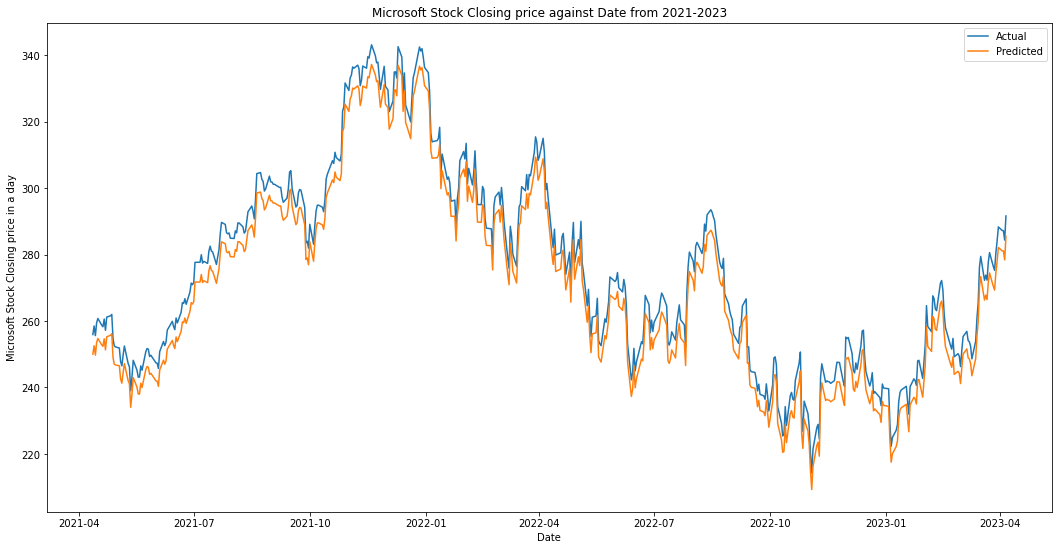

In [10]:
#Prediction by best model
plt.figure(figsize=(18,9))
plt.plot(test2.index[:],test2['Close'])
plt.plot(test2.index[:],y_pred_lr1)
plt.xlabel('Date')
plt.ylabel('Microsoft Stock Closing price in a day')
plt.legend(['Actual','Predicted'])
plt.title('Microsoft Stock Closing price against Date from 2021-2023')
plt.show()

In [11]:
print('PRICE MOVEMENT EXPERIMENT')
# PRICE MOVEMENT PREDICTION (EXPERIMENT 2)
train1=train1.drop(['Close'],axis=1)
test1=test1.drop(['Close'],axis=1)
train1,test1=train1.dropna(),test1.dropna()

x_trainn=train1.iloc[:,1:-1]
x_testt=test1.iloc[:,1:-1]
x_train=train1.iloc[:,1:-1].values
x_test=test1.iloc[:,1:-1].values
y_train=train1.iloc[:,-1].values
y_test=test1.iloc[:,-1].values

# selecting features by SelectKBest Technique
select=SelectKBest(score_func=f_classif,k=7)
select.fit(x_train,y_train)
x_train=select.transform(x_train)
x_test=select.transform(x_test)
print('Selected features for Price Movement prediction:',list(x_trainn.columns[select.get_support()]))
# Scaling dataset
scaler = MinMaxScaler()
x_train= scaler.fit_transform(x_train)
x_test= scaler.transform(x_test)
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)
# SVM
svm=SVC(kernel='linear',probability=True)
svm=svm.fit(x_train,y_train)
y_pred_svm=svm.predict(x_test)
print('SVM:',classification_report(y_test,y_pred_svm))
print()
# Logistic Regression
lr=LogisticRegression(penalty='none',solver='newton-cg')
lr=lr.fit(x_train,y_train)
y_pred_lr=lr.predict(x_test)
print('Logistic regression:',classification_report(y_test,y_pred_lr))
print('Coefficient for Logistic regression:',lr.coef_)
print('Intercept for logistic regression',lr.intercept_)
print()

# Bagging Classifier
bg=BaggingClassifier()
bg=bg.fit(x_train,y_train)
y_pred_bg=bg.predict(x_test)
print('BG:',classification_report(y_test,y_pred_bg))
print()
# Decision Tree
dt=DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=0)
dt=dt.fit(x_train,y_train)
y_pred_dt=dt.predict(x_test)
print('Decision Tree:',classification_report(y_test,y_pred_dt))
print()
# Random forest
rf=RandomForestClassifier(bootstrap=True,n_estimators=100,random_state=0)
rf=rf.fit(x_train,y_train)
y_pred_rf=rf.predict(x_test)
print('Random Forest:',classification_report(y_test,y_pred_rf))

print()
#ANN
ann=MLPClassifier()
ann=ann.fit(x_train,y_train)
y_pred_ann=ann.predict(x_test)
print('ANN:',classification_report(y_test,y_pred_ann))



PRICE MOVEMENT EXPERIMENT
Selected features for Price Movement prediction: ['Adj Close', 'H-L', 'C-O', 'rsi', 'MA14', 'MA21', 'STD7']
SVM:               precision    recall  f1-score   support

           0       0.88      0.65      0.74       257
           1       0.71      0.91      0.80       245

    accuracy                           0.77       502
   macro avg       0.79      0.78      0.77       502
weighted avg       0.80      0.77      0.77       502


Logistic regression:               precision    recall  f1-score   support

           0       0.78      0.67      0.72       257
           1       0.70      0.80      0.74       245

    accuracy                           0.73       502
   macro avg       0.74      0.73      0.73       502
weighted avg       0.74      0.73      0.73       502

Coefficient for Logistic regression: [[10.6854474  -0.26154805  3.31119271  0.04038246 -9.75900703 -0.86329347
   0.17576639]]
Intercept for logistic regression [0.31830304]

BG:       

In [12]:

# THRESHOLD CALCULATIONS TO PLOT ROC CURVE
THRESHOLD = [.75, .80, .85]
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true pos rate", "true neg rate", "false pos rate", "precision", "f-score"]) # df to store results
results['THRESHOLD'] = THRESHOLD                                                                           # threshold column
n_test = len(y_test)

Q = ann.predict_proba(x_test)[:,1]

j = 0                                                                                                      
for i in THRESHOLD:    # iterate over each threshold        
                         # fit data to model
    preds = np.where(Q>i, 1, 0)     # if prob > threshold, predict 1
    
    cm = (confusion_matrix(y_test, preds,labels=[1, 0], sample_weight=None)/n_test)*100 
    # confusion matrix (in percentage)
    
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')      
    
    TP = cm[0][0]                                                                                          # True Positives
    FN = cm[0][1]                                                                                          # False Positives
    FP = cm[1][0]                                                                                          # True Negatives
    TN = cm[1][1]                                                                                          # False Negatives
        
    results.iloc[j,1] = accuracy_score(y_test, preds) 
    results.iloc[j,2] = recall_score(y_test, preds)
    results.iloc[j,3] = TN/(FP+TN)                                                                         # True negative rate
    results.iloc[j,4] = FP/(FP+TN)                                                                         # False positive rate
    results.iloc[j,5] = precision_score(y_test, preds)
    results.iloc[j,6] = f1_score(y_test, preds)
   
    j += 1

print('ALL METRICS FOR ANN')
print(results.T.to_string(header=False))
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true pos rate", "true neg rate", "false pos rate", "precision", "f-score"]) # df to store results
results['THRESHOLD'] = THRESHOLD                                                                           # threshold column
n_test = len(y_test)

Y= bg.predict_proba(x_test)[:,1]

j = 0                                                                                                      
for i in THRESHOLD:    # iterate over each threshold        
                         # fit data to model
    preds = np.where(Y>i, 1, 0)     # if prob > threshold, predict 1
    
    cm = (confusion_matrix(y_test, preds,labels=[1, 0], sample_weight=None)/n_test)*100 
    # confusion matrix (in percentage)
    
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')      
    
    TP = cm[0][0]                                                                                          # True Positives
    FN = cm[0][1]                                                                                          # False Positives
    FP = cm[1][0]                                                                                          # True Negatives
    TN = cm[1][1]                                                                                          # False Negatives
        
    results.iloc[j,1] = accuracy_score(y_test, preds) 
    results.iloc[j,2] = recall_score(y_test, preds)
    results.iloc[j,3] = TN/(FP+TN)                                                                         # True negative rate
    results.iloc[j,4] = FP/(FP+TN)                                                                         # False positive rate
    results.iloc[j,5] = precision_score(y_test, preds)
    results.iloc[j,6] = f1_score(y_test, preds)
   
    j += 1

print('ALL METRICS FOR BG')
print(results.T.to_string(header=False))                                                                         # threshold column
n_test = len(y_test)

Z = dt.predict_proba(x_test)[:,1]

j = 0                                                                                                      
for i in THRESHOLD:    # iterate over each threshold        
                         # fit data to model
    preds = np.where(Z>i, 1, 0)     # if prob > threshold, predict 1
    
    cm = (confusion_matrix(y_test, preds,labels=[1, 0], sample_weight=None)/n_test)*100 
    # confusion matrix (in percentage)
    
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')      
    
    TP = cm[0][0]                                                                                          # True Positives
    FN = cm[0][1]                                                                                          # False Positives
    FP = cm[1][0]                                                                                          # True Negatives
    TN = cm[1][1]                                                                                          # False Negatives
        
    results.iloc[j,1] = accuracy_score(y_test, preds) 
    results.iloc[j,2] = recall_score(y_test, preds)
    results.iloc[j,3] = TN/(FP+TN)                                                                         # True negative rate
    results.iloc[j,4] = FP/(FP+TN)                                                                         # False positive rate
    results.iloc[j,5] = precision_score(y_test, preds)
    results.iloc[j,6] = f1_score(y_test, preds)
   
    j += 1

print('ALL METRICS FOR DECISION TREE')
print(results.T.to_string(header=False))
O = svm.predict_proba(x_test)[:,1]

j = 0                                                                                                      
for i in THRESHOLD:    # iterate over each threshold        
                         # fit data to model
    preds = np.where(O>i, 1, 0)     # if prob > threshold, predict 1
    
    cm = (confusion_matrix(y_test, preds,labels=[1, 0], sample_weight=None)/n_test)*100 
    # confusion matrix (in percentage)
    
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')      
    
    TP = cm[0][0]                                                                                          # True Positives
    FN = cm[0][1]                                                                                          # False Positives
    FP = cm[1][0]                                                                                          # True Negatives
    TN = cm[1][1]                                                                                          # False Negatives
        
    results.iloc[j,1] = accuracy_score(y_test, preds) 
    results.iloc[j,2] = recall_score(y_test, preds)
    results.iloc[j,3] = TN/(FP+TN)                                                                         # True negative rate
    results.iloc[j,4] = FP/(FP+TN)                                                                         # False positive rate
    results.iloc[j,5] = precision_score(y_test, preds)
    results.iloc[j,6] = f1_score(y_test, preds)
   
    j += 1

print('ALL METRICS FOR SUPPORT VECTOR MACHINE')
print(results.T.to_string(header=False))
X = lr.predict_proba(x_test)[:,1]

j = 0                                                                                                      
for i in THRESHOLD:  
    preds = np.where(X>i, 1, 0)
    cm = (confusion_matrix(y_test, preds,labels=[1, 0], sample_weight=None)/n_test)*100 
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')      
    
    TP = cm[0][0]                                                                                          # True Positives
    FN = cm[0][1]                                                                                          # False Positives
    FP = cm[1][0]                                                                                          # True Negatives
    TN = cm[1][1]                                                                                          # False Negatives
        
    results.iloc[j,1] = accuracy_score(y_test, preds) 
    results.iloc[j,2] = recall_score(y_test, preds)
    results.iloc[j,3] = TN/(FP+TN)                                                                         # True negative rate
    results.iloc[j,4] = FP/(FP+TN)                                                                         # False positive rate
    results.iloc[j,5] = precision_score(y_test, preds)
    results.iloc[j,6] = f1_score(y_test, preds)
   
    j += 1

print('ALL METRICS FOR LOGISTIC REGRESSION ')
print(results.T.to_string(header=False))
P = rf.predict_proba(x_test)[:,1]

j = 0                                                                                                      
for i in THRESHOLD: 
    preds = np.where(P>i, 1, 0)
    cm = (confusion_matrix(y_test, preds,labels=[1, 0], sample_weight=None)/n_test)*100 
    # confusion matrix (in percentage)
    
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')      
    
    TP = cm[0][0]                                                                                          # True Positives
    FN = cm[0][1]                                                                                          # False Positives
    FP = cm[1][0]                                                                                          # True Negatives
    TN = cm[1][1]                                                                                          # False Negatives
        
    results.iloc[j,1] = accuracy_score(y_test, preds) 
    results.iloc[j,2] = recall_score(y_test, preds)
    results.iloc[j,3] = TN/(FP+TN)                                                                         # True negative rate
    results.iloc[j,4] = FP/(FP+TN)                                                                         # False positive rate
    results.iloc[j,5] = precision_score(y_test, preds)
    results.iloc[j,6] = f1_score(y_test, preds)
   
    j += 1

print('ALL METRICS FOR RANDOM FOREST')
print(results.T.to_string(header=False))

# Cost function calculations
y_train_pred=bg.predict_proba(x_train)
y_test_pred=bg.predict_proba(x_test)
mle_v_train=np.log(np.where(y_train==1,y_train_pred[:,1],y_train_pred[:,0]))
cf_train=np.negative(np.sum(mle_v_train)/len(y_train))
mle_v_test=np.log(np.where(y_test==1,y_test_pred[:,1],y_test_pred[:,0]))
cf_test=np.negative(np.sum(mle_v_test)/len(y_test))
print("Cost Function for Training set (BG):",cf_train)
print("Cost Function for Testing set (BG):",cf_test)
print()

y_train_pred=dt.predict_proba(x_train)
y_test_pred=dt.predict_proba(x_test)
mle_v_train=np.log(np.where(y_train==1,y_train_pred[:,1],y_train_pred[:,0]))
cf_train=np.negative(np.sum(mle_v_train)/len(y_train))
mle_v_test=np.log(np.where(y_test==1,y_test_pred[:,1],y_test_pred[:,0]))
cf_test=np.negative(np.sum(mle_v_test)/len(y_test))
print("Cost Function for Training set (Decision Tree):",cf_train)
print("Cost Function for Testing set (Decision Tree):",cf_test)
print()

y_train_pred=lr.predict_proba(x_train)
y_test_pred=lr.predict_proba(x_test)
mle_v_train=np.log(np.where(y_train==1,y_train_pred[:,1],y_train_pred[:,0]))
cf_train=np.negative(np.sum(mle_v_train)/len(y_train))
mle_v_test=np.log(np.where(y_test==1,y_test_pred[:,1],y_test_pred[:,0]))
cf_test=np.negative(np.sum(mle_v_test)/len(y_test))
print("Cost Function for Training set (LOGISTIC REGRESSION):",cf_train)
print("Cost Function for Testing set (LOGISTIC REGRESSION):",cf_test)
print()

y_train_pred=rf.predict_proba(x_train)
y_test_pred=rf.predict_proba(x_test)
mle_v_train=np.log(np.where(y_train==1,y_train_pred[:,1],y_train_pred[:,0]))
cf_train=np.negative(np.sum(mle_v_train)/len(y_train))
mle_v_test=np.log(np.where(y_test==1,y_test_pred[:,1],y_test_pred[:,0]))
cf_test=np.negative(np.sum(mle_v_test)/len(y_test))
print("Cost Function for Training set (RANDOM FOREST):",cf_train)
print("Cost Function for Testing set (RANDOM FOREST):",cf_test)
print()
y_train_pred=svm.predict_proba(x_train)
y_test_pred=svm.predict_proba(x_test)
mle_v_train=np.log(np.where(y_train==1,y_train_pred[:,1],y_train_pred[:,0]))
cf_train=np.negative(np.sum(mle_v_train)/len(y_train))
mle_v_test=np.log(np.where(y_test==1,y_test_pred[:,1],y_test_pred[:,0]))
cf_test=np.negative(np.sum(mle_v_test)/len(y_test))
print("Cost Function for Training set (SVM):",cf_train)
print("Cost Function for Testing set (SVM):",cf_test)
print()
y_train_pred=ann.predict_proba(x_train)
y_test_pred=ann.predict_proba(x_test)
mle_v_train=np.log(np.where(y_train==1,y_train_pred[:,1],y_train_pred[:,0]))
cf_train=np.negative(np.sum(mle_v_train)/len(y_train))
mle_v_test=np.log(np.where(y_test==1,y_test_pred[:,1],y_test_pred[:,0]))
cf_test=np.negative(np.sum(mle_v_test)/len(y_test))
print("Cost Function for Training set (ANN):",cf_train)
print("Cost Function for Testing set (ANN):",cf_test)

#ROC PLOT
fpr, tpr, _ = roc_curve(y_test, Q)
roc_auc = auc(fpr,tpr)
fpr1, tpr1, _ = roc_curve(y_test, O)
roc_auc1 = auc(fpr1,tpr1)
fpr2, tpr2, _ = roc_curve(y_test, P)
roc_auc2 = auc(fpr2,tpr2)
fpr3, tpr3, _ = roc_curve(y_test, X)
roc_auc3 = auc(fpr3,tpr3)
fpr4, tpr4, _ = roc_curve(y_test, Y)
roc_auc4 = auc(fpr4,tpr4)
fpr5, tpr5, _ = roc_curve(y_test, Z)
roc_auc5 = auc(fpr5,tpr5)

Confusion matrix for threshold = 0.75
[[37.64940239 11.15537849]
 [ 5.57768924 45.61752988]]
 
Confusion matrix for threshold = 0.8
[[35.25896414 13.54581673]
 [ 4.98007968 46.21513944]]
 
Confusion matrix for threshold = 0.85
[[33.66533865 15.13944223]
 [ 3.58565737 47.60956175]]
 
ALL METRICS FOR ANN
THRESHOLD           0.75       0.8      0.85
accuracy        0.832669  0.814741  0.812749
true pos rate   0.771429  0.722449  0.689796
true neg rate   0.891051  0.902724  0.929961
false pos rate  0.108949  0.097276  0.070039
precision       0.870968  0.876238  0.903743
f-score         0.818182  0.791946  0.782407
Confusion matrix for threshold = 0.75
[[29.08366534 19.72111554]
 [ 4.98007968 46.21513944]]
 
Confusion matrix for threshold = 0.8
[[23.30677291 25.49800797]
 [ 3.38645418 47.80876494]]
 
Confusion matrix for threshold = 0.85
[[23.30677291 25.49800797]
 [ 3.38645418 47.80876494]]
 
ALL METRICS FOR BG
THRESHOLD           0.75       0.8      0.85
accuracy        0.752988  0.71115

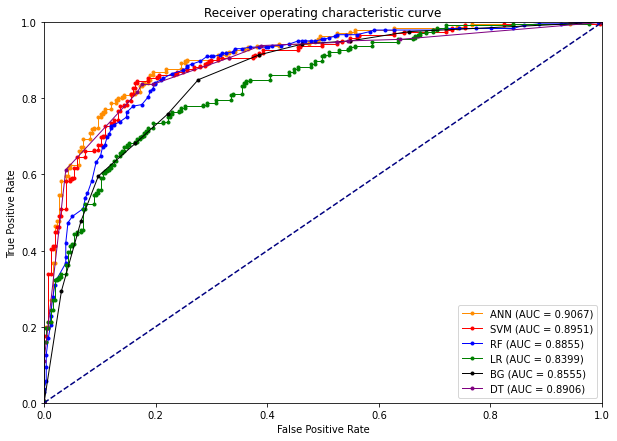

In [13]:
plt.figure(figsize=(10,7)) 
lw = 1
plt.plot(fpr, tpr, color='darkorange', marker='.',lw=lw, label='ANN (AUC = %0.4f)' % roc_auc)
plt.plot(fpr1, tpr1, color='red', marker='.',lw=lw, label='SVM (AUC = %0.4f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='blue', marker='.',lw=lw, label='RF (AUC = %0.4f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='green', marker='.',lw=lw, label='LR (AUC = %0.4f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='black', marker='.',lw=lw, label='BG (AUC = %0.4f)' % roc_auc4)
plt.plot(fpr5, tpr5, color='purple', marker='.',lw=lw, label='DT (AUC = %0.4f)' % roc_auc5)
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()